
## A/B-эксперимент: Статистический анализ

**Вводные данные**

Продукт – мобильное приложении с ежедневными мотивирующими цитатами. Приложение работает по бесплатному доступу, но в полной мере раскрывается только после оплаты подписки. Также внутри приложения есть разовые покупки, которые можно совершить вне зависимости от наличия подписки. Попросили подвести итоги по АБ эксперименту. Надо провести эксперимент как будто бы  «с нуля», чтобы перепроверить все важные аспекты. Необходимо провести полный цикл АБ-эксперимента на основе данных результата АБ-теста – paymentChange. Его проводили на новых пользователях сплитом 50/50. Эксперимент заключался в снижении стоимости подписки с 400 до 160 у. е. 

Важное уточнение: в продукте могут быть параллельно тесты

## Постановка задачи

### Проблематика
У мобильного приложения наблюдается **низкая конверсия в покупку подписки**. Основная задача — **увеличить количество платящих пользователей** и, как следствие, общую выручку продукта.

### Продуктовая гипотеза
> **Если снизить стоимость подписки**, пользователи станут охотнее её приобретать, что приведёт к **росту ключевой метрики — конверсии в платящего пользователя (CR)**.  
На данный момент эта метрика остаётся на низком уровне и ограничивает рост выручки.

### Ключевые метрики

- **Ключевая метрика:** CR в платящего пользователя  
- **Заградительная метрика:** Revenue

>  **Не используем Revenue как основную метрику**, поскольку:
> - объём данных ограничен;
> - платящие пользователи могут принести больше денег в будущем (LTV);
> - важнее протестировать механизм роста CR.

### Целесообразность эксперимента
Эксперимент **оправдан** с точки зрения затрат и рисков:
- В минимуме — занимает слот экспериментов и требует разработки;
- В максимуме — может снизить метрики при неправильной цене.

> Эксперимент оправдан, **если рост CR** сможет **компенсировать потерю в цене**. Ключевая задача — рассчитать, **насколько должна вырасти конверсия**, чтобы итоговый ARPU (выручка на пользователя) остался прежним или вырос.

### План действий (Action Plan)

| Сценарий      | Действие                                                        |
|---------------|------------------------------------------------------------------|
| ✅ Успех      | Раскатываем цену на всех пользователей                          |
| ❌ Неудача    | Анализируем CR и ARPU, предлагаем альтернативную цену           |

### Дальнейшие шаги

- Тестирование **других ценовых точек** для оценки **эластичности спроса**
- Сегментация пользователей (по гео, источникам трафика и др.)
- Оценка долгосрочной выгоды через модели LTV

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, norm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [7]:
# 2. Загрузка данных
actions = pd.read_csv("Action.csv")
payments = pd.read_csv("Payment.csv")
experiments = pd.read_csv("Experiments.csv")

In [28]:
print(actions.head())
print(payments.head())
print(experiments.head())

     uid                   Ts     Action
0  cfjqq  2020-01-16 09:24:32  firstOpen
1  cfjqq  2020-01-16 15:39:41  function2
2  cfjqq  2020-01-16 15:58:21  function4
3  hclau  2020-01-10 22:54:42  firstOpen
4  hclau  2020-01-11 01:19:03  function1
     uid paymentType  Payment
0  hclau       type1      400
1  hclau       type2      200
2  bkhtq       type2      200
3  rxxdh       type2      200
4  qxjhx       type1      400
     Experiment Group    uid
0  actionChange   Old  cfjqq
1  actionChange   Old  hclau
2  actionChange   Old  bkhtq
3  actionChange   Old  rxxdh
4  actionChange   Old  ccsko


In [8]:
# 3. Обработка
payexp = experiments[experiments["Experiment"] == "paymentChange"]
payments_grouped = payments.groupby("uid", as_index=False).agg({"Payment": "sum"})
merged = payexp.merge(payments_grouped, on="uid", how="left")
merged["Payment"] = merged["Payment"].fillna(0)
merged["Converted"] = merged["Payment"] > 0

In [9]:
# 4. Расчёт сводной статистики
summary = merged.groupby("Group").agg(
    n=("uid", "count"),
    x=("Converted", "sum"),
    revenue=("Payment", "sum"),
    mean_payment=("Payment", "mean"),
    var_payment=("Payment", "var"),
    std_payment=("Payment", "std"),
    median_payment=("Payment", "median"),
    mode_payment=("Payment", lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    min_payment=("Payment", "min"),
    max_payment=("Payment", "max")
).assign(
    cr=lambda d: d.x / d.n,
    arpu=lambda d: d.revenue / d.n
)
summary

,n,x,revenue,mean_payment,var_payment,std_payment,median_payment,mode_payment,min_payment,max_payment,cr,arpu
Group,,,,,,,,,,,,
New,25000,17119,3860640.0,154.425600,15822.102949,125.785941,160.0,0.0,0.0,360.0,0.68476,154.425600
Old,25001,12411,3845800.0,153.825847,34840.662310,186.656536,0.0,0.0,0.0,600.0,0.49642,153.825847


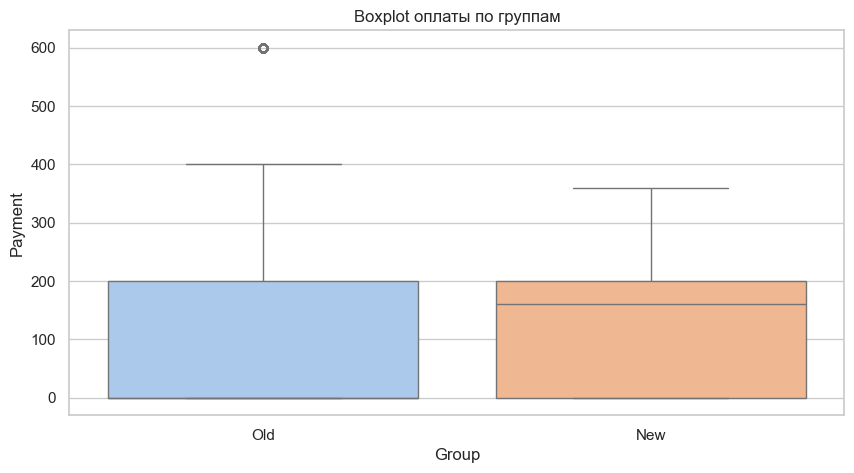

In [20]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged, x="Group", y="Payment", palette='pastel', hue='Group')
plt.title("Boxplot оплаты по группам")
plt.show()

In [27]:
n1, n2 = int(summary.loc["Old", "n"]), int(summary.loc["New", "n"])
x1, x2 = int(summary.loc["Old", "x"]), int(summary.loc["New", "x"])
p1, p2 = x1 / n1, x2 / n2
mean1, mean2 = summary.loc["Old", "mean_payment"], summary.loc["New", "mean_payment"]
var1, var2 = summary.loc["Old", "var_payment"], summary.loc["New", "var_payment"]
std1, std2 = summary.loc["Old", "std_payment"], summary.loc["New", "std_payment"]

In [25]:
# 6. MLE и Рао-Крамер
mle_var1 = (n1 - 1) / n1 * var1
mle_var2 = (n2 - 1) / n2 * var2

rao_var1 = var1 / n1
rao_var2 = var2 / n2

mle_var1, mle_var2, rao_var1, rao_var2

(34839.26873875817, 15821.470064639976, 1.3935707495503267, 0.6328841179503171)

In [23]:
# 7. Доверительные интервалы
ci_old = (mean1 - 1.96 * std1 / np.sqrt(n1), mean1 + 1.96 * std1 / np.sqrt(n1))
ci_new = (mean2 - 1.96 * std2 / np.sqrt(n2), mean2 + 1.96 * std2 / np.sqrt(n2))

ci_old, ci_new

((151.51207485299688, 156.13961907924585),
 (152.8663413211664, 155.9848586788336))

In [24]:
# 8. Проверка гипотез
t_stat, p_val_t = ttest_ind(
    merged[merged["Group"] == "Old"]["Payment"],
    merged[merged["Group"] == "New"]["Payment"],
    equal_var=False
)

p_comb = (x1 + x2) / (n1 + n2)
se_comb = np.sqrt(p_comb * (1 - p_comb) * (1/n1 + 1/n2))
z_stat = (p1 - p2) / se_comb
p_val_z = 2 * (1 - norm.cdf(abs(z_stat)))

p_comb, se_comb, z_stat, p_val_z

(0.5905881882362353, 0.004398080894844028, -42.823190684492175, 0.0)

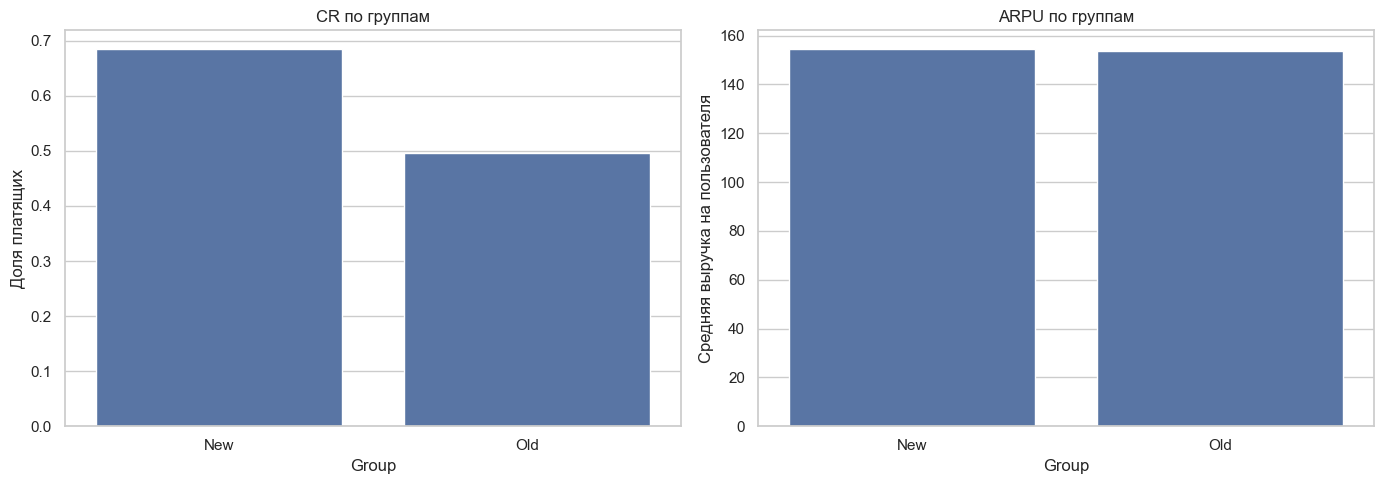

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=summary.reset_index(), x="Group", y="cr", ax=axes[0])
axes[0].set_title("CR по группам")
axes[0].set_ylabel("Доля платящих")

sns.barplot(data=summary.reset_index(), x="Group", y="arpu", ax=axes[1])
axes[1].set_title("ARPU по группам")
axes[1].set_ylabel("Средняя выручка на пользователя")

plt.tight_layout()
plt.show()

In [26]:
# 9. Вывод
print("MLE-дисперсия:", round(mle_var1, 2), "(Old),", round(mle_var2, 2), "(New)")
print("Рао-Крамер Var(x̄):", round(rao_var1, 4), "(Old),", round(rao_var2, 4), "(New)")
print("95% ДИ среднего (Old):", ci_old)
print("95% ДИ среднего (New):", ci_new)
print("t-критерий: t =", round(t_stat, 3), ", p =", round(p_val_t, 3))
print("z-критерий: z =", round(z_stat, 2), ", p =", round(p_val_z, 5))

MLE-дисперсия: 34839.27 (Old), 15821.47 (New)
Рао-Крамер Var(x̄): 1.3936 (Old), 0.6329 (New)
95% ДИ среднего (Old): (151.51207485299688, 156.13961907924585)
95% ДИ среднего (New): (152.8663413211664, 155.9848586788336)
t-критерий: t = -0.421 , p = 0.674
z-критерий: z = -42.82 , p = 0.0
